In [1]:
from typing import Optional, Union, List, Dict, Any

import lightning
import torch, torch_geometric as pyg, networkx as nx, pymimir as mi
import torch_geometric.nn
from torch import Tensor
from torch_geometric.typing import OptTensor, EdgeType, NodeType

In [2]:
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HGTConv, Linear, Aggregation, MessagePassing

In [5]:
import os
os.getcwd()

'/work/rleap1/jakob.krude/projects/remote/rgnet/examples'

In [3]:
from pymimir import State, Problem, Domain
from rgnet.utils import import_all_from

In [6]:
domain, problems = import_all_from("../test/pddl_instances/blocks")

In [7]:
problem: Problem = problems[0]
initial_state = problem.create_state(problem.initial)
initial_state.get_atoms()

[<Atom 'clear(a)'>,
 <Atom 'clear(c)'>,
 <Atom 'ontable(g)'>,
 <Atom 'ontable(f)'>,
 <Atom 'on(a, g)'>,
 <Atom 'on(c, d)'>,
 <Atom 'on(d, b)'>,
 <Atom 'on(b, e)'>,
 <Atom 'on(e, f)'>,
 <Atom 'handempty()'>]

In [8]:
problem.goal

[<Literal 'on(a, e)'>,
 <Literal 'on(e, b)'>,
 <Literal 'on(b, f)'>,
 <Literal 'on(f, g)'>,
 <Literal 'on(g, c)'>,
 <Literal 'on(c, d)'>]

In [9]:
a: mi.Atom = problem.goal[0].atom
a.terms

[<Object 'a'>, <Object 'e'>]

In [10]:
import itertools

# Build hetero graph from state
# One node for each object
# One node for each atom
# Edge label = position in atom
state = problem.create_state(problem.initial)
graph = nx.Graph()

for obj in problem.objects:
    graph.add_node(obj.name, type="obj")

state_atoms = zip(
    filter(lambda a: a.predicate.name != "=", state.get_atoms()),
    itertools.repeat(""),
    itertools.repeat(""),
)
goal_atoms = (
    (literal.atom, "~" if literal.negated else "", "_g")
    for literal in problem.goal
)

for atom, prefix, suffix in itertools.chain(state_atoms, goal_atoms):

    if atom.predicate.arity == 0:
        continue

    predicate: mi.Predicate = atom.predicate
    pred_name: str = predicate.name
    node_type = f"{prefix}{pred_name}{suffix}"
    graph.graph[node_type] = predicate.arity

    obj_names = ",".join(obj.name for obj in atom.terms)

    atom_node = f"{prefix}{pred_name}({obj_names}){suffix}"
    graph.add_node(
        atom_node,
        type=node_type,
    )

    for pos, obj in enumerate(atom.terms):
        # Connect predicate node to object node
        graph.add_edge(obj.name, atom_node, position=str(pos))



In [11]:
from collections import defaultdict

nodes_by_type = defaultdict(list)
for key, value in nx.get_node_attributes(graph, "type").items():
    nodes_by_type[value].append(key)
nodes_by_type

defaultdict(list,
            {'obj': ['e', 'b', 'd', 'f', 'g', 'c', 'a'],
             'clear': ['clear(a)', 'clear(c)'],
             'ontable': ['ontable(g)', 'ontable(f)'],
             'on': ['on(a,g)', 'on(c,d)', 'on(d,b)', 'on(b,e)', 'on(e,f)'],
             'on_g': ['on(a,e)_g',
              'on(e,b)_g',
              'on(b,f)_g',
              'on(f,g)_g',
              'on(g,c)_g',
              'on(c,d)_g']})

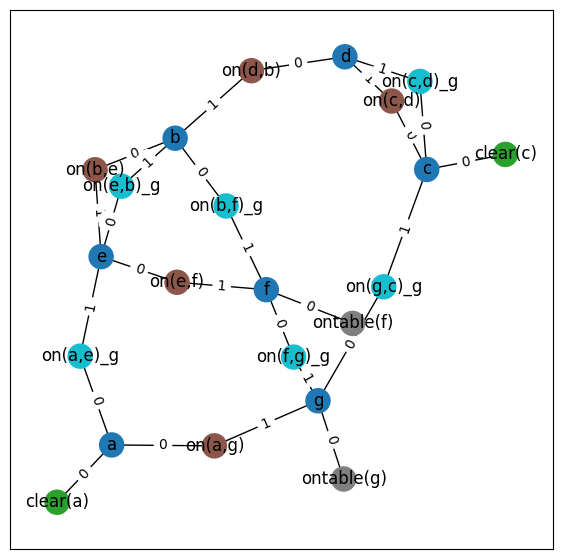

In [12]:
from matplotlib import pyplot as plt

type_to_color = {ntype: i for i, ntype in
                 enumerate(set(nx.get_node_attributes(graph, "type").values()))}
pos = nx.spring_layout(graph)
plt.figure(figsize=(7, 7))

nx.draw_networkx(
    graph,
    pos=pos,
    with_labels=True,
    labels={n: str(n) for n in graph.nodes},
    nodelist=[n for n in graph.nodes],
    node_color=[type_to_color[attr["type"]] for _, attr in graph.nodes.data()],
    cmap="tab10",
)
nx.draw_networkx_edge_labels(graph, pos=pos,
                             edge_labels={(src, dst): attr["position"] for
                                          src, dst, attr in graph.edges.data()})
plt.show()

In [13]:
node_type = "on_g"
hidden_size = 4
arity = graph.graph[node_type]
# node features arity x hidden_size
node_features = torch.stack(
    [torch.zeros(hidden_size * arity) for _, attr in graph.nodes.data() if
     attr["type"] == node_type])
node_features

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
torch.zeros(len([1 for _, attr in graph.nodes.data() if attr["type"] == node_type]),
            hidden_size)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [ ]:
from torch_geometric.data import HeteroData

In [ ]:
obj_label = sorted([node for node, attr in graph.nodes.data() if attr["type"] == "obj"])
obj_label = {o: i for i, o in enumerate(obj_label)}
obj_label

In [ ]:
torch.stack(
    [torch.full(fill_value=obj_label[node], size=(2,)) for node, attr in
     graph.nodes.data() if attr["type"] == "obj"])

In [ ]:
# group nodes by type
by_type = {ntype: [node for node, attr in graph.nodes.data() if attr["type"] == ntype]
           for
           ntype in set(nx.get_node_attributes(graph, "type").values())}

nidx_by_type = {ntype: {node: i for i, node in enumerate(by_type[ntype])} for ntype in
                by_type.keys()}
nidx_by_type

In [ ]:
# Build pyg HeteroData from graph
data = HeteroData()
hidden_size = 1
for node_type in set(nx.get_node_attributes(graph, "type").values()):
    if node_type == "obj":
        data[node_type].x = torch.stack(
            [torch.full(fill_value=obj_label[node], size=(hidden_size,),
                        dtype=torch.float32) for node, attr
             in graph.nodes.data() if attr["type"] == node_type])
    else:
        arity = graph.graph[node_type]
        data[node_type].x = torch.stack(
            [torch.zeros(arity * hidden_size, dtype=torch.float32) for _, attr in
             graph.nodes.data() if
             attr["type"] == node_type])

# Group edges by src, position, dst
edge_dict = {}
for src, dst, attr in graph.edges.data():
    src_type = graph.nodes[src]["type"]
    dst_type = graph.nodes[dst]["type"]
    if (src_type, attr["position"], dst_type) not in edge_dict:
        edge_dict[(src_type, attr["position"], dst_type)] = []
        edge_dict[(dst_type, attr["position"], src_type)] = []

    edge_dict[(src_type, attr["position"], dst_type)].append(
        torch.tensor([nidx_by_type[src_type][src], nidx_by_type[dst_type][dst]]))
    edge_dict[(dst_type, attr["position"], src_type)].append(
        torch.tensor([nidx_by_type[dst_type][dst], nidx_by_type[src_type][src]]))
# stack grouped tensors and add to data
for key, value in edge_dict.items():
    data[key[0], key[1], key[2]].edge_index = torch.stack(value, dim=1)

edge_types = edge_dict.keys()

In [ ]:
torch.stack([torch.tensor([1, 2]), torch.tensor([3, 4]), torch.tensor([5, 6])], dim=1)

In [ ]:
data.validate()

In [ ]:
data.x_dict

In [ ]:
from torch_geometric.utils import to_networkx

hgraph: nx.Graph = to_networkx(data, to_multi=True)
pos = nx.spring_layout(hgraph)
nx.draw_networkx(hgraph)

In [ ]:
class SelectMP(pyg.nn.SimpleConv):

    def __init__(self,
                 position: int,
                 aggr: Optional[Union[str, List[str]]] = 'sum', *,
                 aggr_kwargs: Optional[Dict[str, Any]] = None,
                 flow: str = "source_to_target",
                 node_dim: int = -2,
                 decomposed_layers: int = 1) -> None:
        super().__init__(aggr, aggr_kwargs=aggr_kwargs, flow=flow, node_dim=node_dim,
                         decomposed_layers=decomposed_layers)
        self.position = position

    def message(self, x_j: Tensor) -> Tensor:
        selected = x_j[:, self.position].view(-1, 1)
        print("Selected:")
        print(selected)
        return selected



In [ ]:
from typing import Optional, Union, List
from torch import Tensor


class MP(pyg.nn.SimpleConv):

    def __init__(self, aggr: Optional[Union[str, List[str]]] = "sum",
                 combine_root: Optional[str] = None, **kwargs):
        super().__init__(aggr, combine_root, **kwargs)

    def forward(self, x, edge_index) -> Tensor:
        print("Forward: ")
        print(x)
        print(edge_index)
        print()
        return super().forward(x, edge_index)

    def message(self, x_j: Tensor, edge_weight) -> Tensor:
        print("Message: ")
        print(x_j)
        return super().message(x_j, edge_weight)

    def aggregate(self, inputs, index, ptr, dim_size) -> Tensor:
        print("Aggregate: ")
        print(inputs)
        print(index)
        print(ptr)
        print(dim_size)
        return super().aggregate(inputs, index, ptr, dim_size)



In [ ]:
data

In [ ]:
from torch_geometric.nn.module_dict import ModuleDict
from torch_geometric.nn import HeteroConv, SimpleConv
from torch_geometric.typing import EdgeType, NodeType


class FanOutMP(torch.nn.Module):

    def __init__(self,
                 edge_types: List[EdgeType],
                 update_mlp_by_dst: Dict[str, torch.nn.Module]
                 ):

        super().__init__()
        self.edge_types = edge_types
        self.update_mlp_by_dst = ModuleDict(update_mlp_by_dst)
        self.simple = SimpleConv()

    def forward(self, *args_dict, **kwargs_dict) -> Dict[NodeType, Tensor]:
        out_dict: Dict[str, List[Tensor]] = {}
        print("FanOut forward:" + str(self.edge_types))
        for edge_type in self.edge_types:
            src, rel, dst = edge_type
            has_edge_level_arg = False

            args = []
            for value_dict in args_dict:
                if edge_type in value_dict:
                    has_edge_level_arg = True
                    args.append(value_dict[edge_type])
                elif src == dst and src in value_dict:
                    args.append(value_dict[src])
                elif src in value_dict or dst in value_dict:
                    args.append((
                        value_dict.get(src, None),
                        value_dict.get(dst, None),
                    ))

            kwargs = {}
            for arg, value_dict in kwargs_dict.items():
                if not arg.endswith('_dict'):
                    raise ValueError(
                        f"Keyword arguments in '{self.__class__.__name__}' "
                        f"need to end with '_dict' (got '{arg}')")

                arg = arg[:-5]  # `{*}_dict`
                if edge_type in value_dict:
                    has_edge_level_arg = True
                    kwargs[arg] = value_dict[edge_type]
                elif src == dst and src in value_dict:
                    kwargs[arg] = value_dict[src]
                elif src in value_dict or dst in value_dict:
                    kwargs[arg] = (
                        value_dict.get(src, None),
                        value_dict.get(dst, None),
                    )

            if not has_edge_level_arg:
                continue

            out = self.simple(*args, **kwargs)  # one entry for every node of type dst 
            pos = int(rel)
            if dst not in out_dict:
                out_dict[dst] = [(pos, out)]
            else:
                out_dict[dst].append((pos, out))

        for dst, value in out_dict.items():
            sorted_out = sorted(value, key=lambda x: x[0])
            stacked = torch.cat([out for _, out in sorted_out], dim=1)
            print("Fan out stacked:")
            print(stacked)
            out_dict[dst] = self.update_mlp_by_dst[dst](stacked)

        return out_dict


In [ ]:


class HGT(torch.nn.Module):
    def __init__(self,
                 hidden_channels,
                 out_channels,
                 num_layer: int,
                 edge_to_obj,
                 edge_to_atom,
                 arity_by_pred: Dict[str, int],
                 ):
        super().__init__()

        self.num_layer = num_layer
        mlp_by_pred = {
            pred: pyg.nn.MLP([arity_by_pred[pred] * hidden_channels, hidden_channels,
                              arity_by_pred[pred] * hidden_channels, ]) for
            _, _, pred in edge_to_atom}

        self.obj_to_atom = FanOutMP(edge_to_atom, mlp_by_pred)

        self.obj_update = pyg.nn.MLP(
            [hidden_channels * 2, hidden_channels, hidden_channels])
        self.atom_to_obj = HeteroConv({
            (src, pos, dst): SelectMP(int(pos)) for src, pos, dst in edge_to_obj}
        )
        self.lin = Linear(hidden_channels, out_channels)

    def layer(self, x_dict, edge_index_dict):
        out = self.obj_to_atom(x_dict, edge_index_dict)  # flows from objects to atoms
        x_dict.update(out)  # update atom embeddings
        out = self.atom_to_obj(x_dict, edge_index_dict)  # flows form atoms to objects
        # group old embedding current embedding for each object
        obj_emb = torch.cat([x_dict["obj"], out["obj"]], dim=1)
        obj_emb = self.obj_update(obj_emb)  # run through update-mlp
        x_dict.update({"obj": obj_emb})

    def forward(self, x_dict, edge_index_dict):
        for _ in range(self.num_layer):
            self.layer(x_dict, edge_index_dict)
        return self.lin(x_dict['obj'])


In [ ]:
to_atom = [(src, pos, dst) for src, pos, dst in edge_types if dst != "obj"]
to_obj = [(src, pos, dst) for src, pos, dst in edge_types if dst == "obj"]
model = HGT(hidden_channels=hidden_size, out_channels=1, edge_to_obj=to_obj,
            edge_to_atom=to_atom, arity_by_pred=dict(graph.graph.items()), num_layer=1)

In [ ]:
model(data.x_dict, data.edge_index_dict)

In [ ]:
t1 = torch.tensor([[1., 2.0],
                   [3., 4.0],
                   [5., 6.0],
                   [7., 8.]])

t2 = torch.tensor([[8., 7.],
                   [6., 5.],
                   [4., 3.0],
                   [2., 1.0]])
torch.cat([t1, t2], dim=1)

In [ ]:
x = torch.tensor([[1],
                  [0],
                  [2]])

# Select the 2nd element from each row
selected_elements = x[:, 0].view(-1, 1)

print(selected_elements)

In [ ]:
torch.zeros((2, 3))

In [ ]:
from rgnet.models.hetero_gnn import HGT
from rgnet.pddl_import import import_all_from
from rgnet.encoding.hetero import HeteroEncoding
from rgnet.supervised.data import MultiInstanceSupervisedSet
from torch_geometric.loader import DataLoader
import torch

hidden_size = 4

domain, problems = import_all_from("test/pddl_instances/blocks")
encoder = HeteroEncoding(domain, hidden_size=hidden_size)
train_set = MultiInstanceSupervisedSet(problems, encoder, force_reload=True)
train_loader = DataLoader(train_set, batch_size=2, shuffle=True)

model = HGT(hidden_channels=hidden_size, out_channels=1, num_layer=1,
            arity_by_pred=encoder.arity_by_pred, obj_name=encoder.obj_name)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.L1Loss()

batch = next(iter(train_loader))

In [ ]:
batch["obj"].batch

In [ ]:
hasattr(batch["obj"], "batch")

In [ ]:
import importlib
import rgnet
importlib.reload(rgnet.models.hetero_gnn)

In [ ]:
from rgnet.models.hetero_gnn import LightningHetero
from rgnet.supervised.data import MultiInstanceSupervisedSet
from rgnet.pddl_import import import_all_from
from rgnet.encoding.hetero import HeteroEncoding

In [ ]:
domain, problems = import_all_from("test/pddl_instances/blocks")

In [ ]:
encoder = HeteroEncoding(domain, hidden_size=4)

In [ ]:
import tempfile

In [ ]:
tempdir = tempfile.mkdtemp()

In [ ]:
tempdir

In [ ]:
dataset = MultiInstanceSupervisedSet(problems, encoder, force_reload=True, root=tempdir)

In [ ]:
from torch_geometric.loader import DataLoader 
import lightning

In [ ]:
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [ ]:
model = LightningHetero(hidden_size=4, num_layer=1,
                        arity_by_pred=encoder.arity_by_pred, obj_name=encoder.obj_name)

In [ ]:
isinstance(model, lightning.LightningModule)

In [ ]:
from lightning import Trainer

In [ ]:
trainer = Trainer(max_epochs=1)

In [ ]:
trainer.fit(model, train_dataloaders=train_loader)